In [13]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import lightning as L
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.optim as optim

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np
import tracemalloc 

import json
import os
import glob
import pickle
from itertools import combinations
import gc
import time
import random
import sys

sys.path.insert(0, os.path.join(os.path.abspath(''), ".."))
from model.builder import Classifier1DMaxPoolBNModel
from datamodule.datamodule import DataModule, FFTDataModule
from datamodule import SENSOR_NUM, eng_label_list

import warnings
warnings.filterwarnings("ignore")

In [3]:
L.seed_everything(42)

Seed set to 42


42

In [44]:
missing = 6
user = 0
version = 0

log_save_dir = os.path.join("../data/compgan_dataset/", "results", "84_classify_fft")
log_save_name = f"{missing}_missing/user{user}"

ckpt_dir = os.path.join(log_save_dir, log_save_name, f"version_{version}", "checkpoints")
weight_file = glob.glob(os.path.join(ckpt_dir, "*.ckpt"))[0]

print(weight_file)

../data/compgan_dataset/results/84_classify_fft/1_missing/user0/version_0/checkpoints/sample_epoch=209-step=16800-val_loss=0.096327.ckpt


In [45]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight_file)

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes      | Out sizes    
--------------------------------------------------------------------------
0  | cnn      | Sequential  | 87.6 K | [10, 42, 129] | [10, 128, 12]
1  | cnn.0    | Conv1d      | 21.6 K | [10, 42, 129] | [10, 64, 41] 
2  | cnn.1    | BatchNorm1d | 128    | [10, 64, 41]  | [10, 64, 41] 
3  | cnn.2    | ReLU        | 0      | [10, 64, 41]  | [10, 64, 41] 
4  | cnn.3    | Conv1d      | 65.7 K | [10, 64, 41]  | [10, 128, 12]
5  | cnn.4    | BatchNorm1d | 256    | [10, 128, 12] | [10, 128, 12]
6  | cnn.5    | ReLU        | 0      | [10, 128, 12] | [10, 128, 12]
7  | linear   | Sequential  | 1.9 M  | [10, 1536]    | [10, 10]     
8  | linear.0 | Linear      | 1.6 M  | [10, 1536]    | [10, 1024]   
9  | linear.1 | BatchNorm1d | 2.0 K  | [10, 1024]    | [10, 1024]   
10 | linear.2 | ReLU        | 0      | [10, 1024]    | [10, 1024]   
11 | linear.3 | Linear      | 262 K  | [10, 1024]    | [10, 256]    
12 | linear.4 | BatchNorm1d 

In [46]:
# data_module = FFTDataModule(
#     test_user=user, 
#     missing_sensor_numbers=missing,
#     batch_size=512,
#     test_mode=True)

# data_module.setup("predict")
# print(len(data_module.test_dataset.missing_index_list))
# print(data_module.test_dataset.missing_index_list)

In [47]:
pred_gt_dict = {}

for missing_sensor_numbers in range(SENSOR_NUM):
    # missing from 0 -> SENSOR_NUM - 1
    data_module = FFTDataModule(
        test_user=user, 
        missing_sensor_numbers=missing_sensor_numbers,
        batch_size=512,
        test_mode=True
    )

    trainer = L.Trainer()

    trainer.test(model=net, datamodule=data_module)
    output = trainer.predict(model=net, datamodule=data_module)
    pred = torch.argmax(torch.concat(output), dim=1)
    
    data_module.setup("predict")
    gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))
    
    pred_ravel = pred.numpy()
    gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))
    
    pred_gt_dict[missing_sensor_numbers] = (pred_ravel, gt_ravel)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9626168012619019
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 307.07it/s]
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 217.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9632843732833862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 350.39it/s]
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 223.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9619492888450623
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 348.42it/s]
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 222.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.945794403553009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 238.47it/s]
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 200.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8973297476768494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 243.40it/s]
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 200.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7794837355613708
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 235.77it/s]
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 168.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5560747385025024
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 292.54it/s]
teardown


In [48]:

def eval(gt_ravel, pred_ravel):
    accuracy = accuracy_score(gt_ravel, pred_ravel)
    print("Accuracy", accuracy)

    f1 = f1=f1_score(gt_ravel, pred_ravel, average="macro")
    print("F1", f1)

    cf = confusion_matrix(gt_ravel, pred_ravel)

    print(cf)

    s = sns.heatmap(cf, annot=True, fmt='g')
    s.set(xlabel="Predict", ylabel="Ground truth", xticklabels=eng_label_list, yticklabels=eng_label_list)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

Accuracy 0.9619492656875834
F1 0.9523855335975545
[[ 294    0    0    0    0    0    0    0    0    0]
 [   0  211    1    0    6    0    0   13    0    0]
 [   0    0  420    0    0    0    0    0    0    0]
 [   0    4    1  256   38   16    0    0    0    0]
 [   0    1    0    4  331    0    0    0    0    0]
 [   0    0    0   38    0  315    0    3    0    1]
 [   0    0    0    1    0    0  293    0    0    0]
 [   0    0    0    0    1    0    0  440    0    0]
 [   0    0   41    0    0    0    0    0  756    1]
 [   0    0    0    0    0    0    1    0    0 1007]]


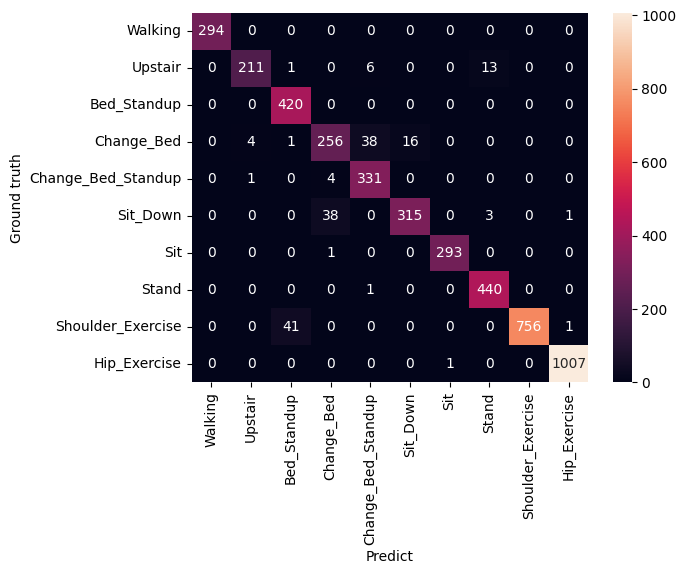

In [64]:
pred_ravel, gt_ravel = pred_gt_dict[2]
eval(gt_ravel, pred_ravel)